# 1. Import libraries

In [20]:
# Data processing  
# -----------------------------------------------------------------------  
import pandas as pd  
import numpy as np

# Pandas option
# -----------------------------------------------------------------------  
pd.options.display.max_colwidth = None
 
# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore")

# Custom functions
# -----------------------------------------------------------------------
from src.eda import * # Revisar qué funciones necesito de aquí
from src.circuit_clustering_model.extract import *
from src.race_prediction_model.extract import *

import fastf1

# Config less verbosity
fastf1.set_log_level('ERROR')

# 2. Data loading

### Seasons

Let’s load the races held between 2018 and 2024 (sprints not included). We are going to carry out the analysis on circuits that have been present at least once during this period. 

The reason for choosing this period is that telemetry data from the single-seaters is only available from 2018 onwards. However, this will provide a representative sample of the circuits from recent years.

### Source of Information

For each circuit, we will select the fastest lap to extract telemetry data and obtain relevant characteristics for classification.

The fastest lap in a race largely depends on the circumstances at the time. Factors such as fuel load, consumption management, tire wear, and race pace can make this lap less representative of the circuit compared to others or even different seasons.

In contrast, during qualifying, the fastest lap is set with new tires, minimal fuel load, and drivers pushing to the absolute limit. Since these conditions are consistent across all Grand Prix events, we will use this lap to extract telemetry and obtain more accurate results.

In [27]:
try:
    df_races = pd.read_csv('../data/output/races.csv')

except FileNotFoundError:
    print("Data not found: Extracting data...")
    df_races = extract_races_dataframe(start=2018, end=2024, save=True)

df_races = df_races.loc[:, ['season', 'round', 'circuitId']]
df_races = df_races[df_races['season'] >= 2018]

We only need each circuit once, so we will remove duplicates and keep the most recent one.

In [32]:
df_unique_circuits = df_races.sort_values(by='season').drop_duplicates(subset=['circuitId'], keep='last')

We have a total of 31 circuits to cluster.

In [34]:
df_unique_circuits.shape

(31, 3)

In [35]:
df_unique_circuits.head()

,season,round,circuitId
187,2019,11,hockenheimring
208,2020,11,nurburgring
206,2020,9,mugello
229,2021,15,sochi
230,2021,16,istanbul


We proceed with extracting the telemetry from the pole position lap. If the data has already been extracted, we simply load the dataset.

In [59]:
try:
    df = pd.read_csv('../data/output/circuits.csv', index_col=0)

except FileNotFoundError:
    print("Data not found: Extracting data...")
    df = extract_races_and_results_dataframes(df_unique_circuits)
    df.to_csv('../data/output/circuits.csv')

If a qualifying session has taken place in wet conditions, the data will be less representative of the circuit’s characteristics. To solve this issue, a column has been added with information about the tire compound used so that, in case of a wet session, we can retrieve the lap from the most recent year that took place in dry conditions.

In [42]:
df[df['compound'].isin(['WET', 'INTERMEDIATE'])]

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,straight_lenght,...,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
spa,INTERMEDIATE,113.159,307.0,6953.411667,19,197.477040,221.3,68.476190,14.523810,4134.880839,...,7,8,0,3,1,7,0,2,1,5
interlagos,INTERMEDIATE,83.405,270.0,4222.174167,15,159.030235,184.5,55.012346,19.444444,1374.534189,...,7,2,0,3,4,3,1,0,1,0


In this case, we see that there are two sessions that took place in wet conditions: `spa` and `interlagos`.

In [47]:
wet_races = df[df['compound'].isin(['WET', 'INTERMEDIATE'])].index.to_list()

df_aux = df_races[df_races['circuitId'].isin(wet_races)]

penultimate_values = df_aux.groupby("circuitId").nth(-2).reset_index()
df_ext = extract_races_and_results_dataframes(penultimate_values)

Processing circuits.: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


We check that the lap from the previous year was in dry conditions (if not, we go back another season).

In [49]:
df_ext

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,straight_lenght,...,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
spa,SOFT,106.168,307.0,6933.692222,19,210.155817,235.492574,74.44802,14.60396,4108.277214,...,7,8,0,3,1,3,4,1,2,5
interlagos,SOFT,70.021,328.0,4234.409722,15,193.910736,218.680297,66.67658,15.98513,1329.373332,...,8,4,0,0,5,1,0,4,1,1


We merge the results of the dry-condition circuits into a single dataframe.

In [60]:
df_circuits = pd.concat([df[df['compound'].isin(['SOFT', 'MEDIUM', 'HARD'])], df_ext])

Note: The Mugello circuit does not have data on the corners. However, since it has only hosted a Grand Prix in 2020 as an exceptional case due to the COVID-19 pandemic, we will leave it aside. This way, we are left with 30 circuits and 22 columns.

In [62]:
df_circuits.shape

(30, 22)

# 3. Data description

## 3.1 Circuit Clustering Features

To effectively cluster the circuits, key characteristics have been collected based on telemetry data from the fastest lap in dry conditions. The selected features (columns in the dataframe) are:

* `compound`: Tire compound used during the pole position lap.

* `laptime`: Total lap time, expressed in seconds.

* `max_speed`: Maximum speed reached at the speed trap, in km/h.

* `distance`: Total circuit length, in meters.

* `n_corners`: Total number of corners in the track.

* `avg_corner_speed`: Average speed through corners, in km/h.

* `avg_speed`: Average lap speed, in km/h.

* `throttle_perc`: Percentage of throttle applied throughout the lap.

* `brake_perc`: Percentage of braking applied throughout the lap.

* `straight_length`: Total length of straights exceeding 500 meters.

* `gear_changes`: Total number of gear shifts during the lap.

* `n_slow_corners`: Total number of slow corners (speed < 120 km/h).

* `n_medium_corners`: Total number of medium-speed corners (120 km/h ≤ speed < 240 km/h).

* `n_fast_corners`: Total number of fast corners (speed ≥ 240 km/h).

* `n_gear{i}_corners`: Total number of corners taken in each gear i (from 1st to 8th).

<span style="color:red;">**Note:**</span> The compound column will not be used for clustering. It was only considered to filter sessions that took place in dry conditions.

In [64]:
df_circuits.columns

Index(['compound', 'laptime', 'max_speed', 'distance', 'n_corners',
       'avg_corner_speed', 'avg_speed', 'throttle_perc', 'brake_perc',
       'straight_lenght', 'gear_changes', 'n_slow_corners', 'n_medium_corners',
       'n_fast_corners', 'n_gear1_corners', 'n_gear2_corners',
       'n_gear3_corners', 'n_gear4_corners', 'n_gear5_corners',
       'n_gear6_corners', 'n_gear7_corners', 'n_gear8_corners'],
      dtype='object')

In [67]:
df_circuits.drop(columns='compound', inplace=True)

## 3.2 Exploratory data analysis

In this case, all the columns are numeric.

In [69]:
df_circuits.head()

,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,straight_lenght,gear_changes,...,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
hockenheimring,71.767,320.0,4568.748333,17,209.960540,229.888136,78.359322,12.881356,1663.919441,40.0,...,9,5,0,1,3,1,3,5,3,1
nurburgring,85.269,318.0,5112.340000,15,173.563856,216.201705,72.281250,17.329545,2043.790918,50.0,...,7,3,0,0,4,3,3,1,2,1
portimao,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,1800.793691,40.0,...,5,6,0,0,4,2,1,4,4,0
sochi,101.993,291.0,5789.306111,18,172.024977,204.520095,69.290780,17.494090,1284.998104,64.0,...,8,5,0,3,7,2,1,1,3,1
istanbul,82.868,321.0,5253.130833,14,176.854350,228.286957,77.663768,15.072464,3877.396258,39.0,...,8,3,0,3,1,4,1,0,2,1


In [71]:
df_circuits.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
laptime,30.0,82.86,10.60,64.31,74.87,82.73,89.44,106.17
max_speed,30.0,319.83,15.82,280.00,314.75,322.50,328.75,347.00
distance,30.0,5135.49,770.99,3238.42,4584.94,5234.80,5744.24,6933.69
n_corners,30.0,16.50,3.19,10.00,14.25,16.00,18.75,27.00
avg_corner_speed,30.0,188.81,23.52,142.33,173.99,189.60,208.03,238.63
avg_speed,30.0,224.14,19.59,164.76,212.76,224.35,235.95,263.48
throttle_perc,30.0,73.33,5.82,58.82,69.34,73.82,77.28,83.73
brake_perc,30.0,16.23,3.63,11.44,13.77,15.67,17.61,27.14
straight_lenght,30.0,2358.30,1117.82,0.00,1441.63,2244.03,3254.38,4762.37
gear_changes,30.0,43.03,8.32,30.00,37.00,41.00,46.75,64.00


### Statistical summary of the dataframe

The statistical summary of the dataframe shows significant variability in circuit characteristics. Some key highlights are:

- `Lap times`: Range from 64.31s to 106.17s, with an average of 82.86s, indicating circuits of varying lengths and complexities.

- `Maximum speed`: An average of 319.83 km/h, with a range between 280 km/h and 347 km/h.

- `Circuit distance`: An average of 5135.49 m, but with a high standard deviation (770.99 m).

- `Number of corners`: An average of 16.5 corners, with circuits featuring between 10 and 27, highlighting variations in design.

- `Average cornering speed`: Around 188.81 km/h, with circuits allowing minimum speeds of 142.33 km/h and maximum speeds of 238.63 km/h.

- `Throttle and brake usage`: The throttle percentage is high (73.33% on average), while brake usage is relatively low (16.23%), which is common in motorsport.

- `Straight length`: Highly variable (0 m to 4762.37 m), with an average of 2358.30 m, indicating circuits with very different configurations. Note that circuits with 0 m of straights do not mean they have no straights, but rather that there are no straights longer than 500 m.

- `Corner distribution by gear`: Most corners are taken in third to seventh gear, with very few in first, second, or eighth. Very low gears are usually used only at the start or in the pit lane, while eighth gear is only used on long straights.


### Outliers

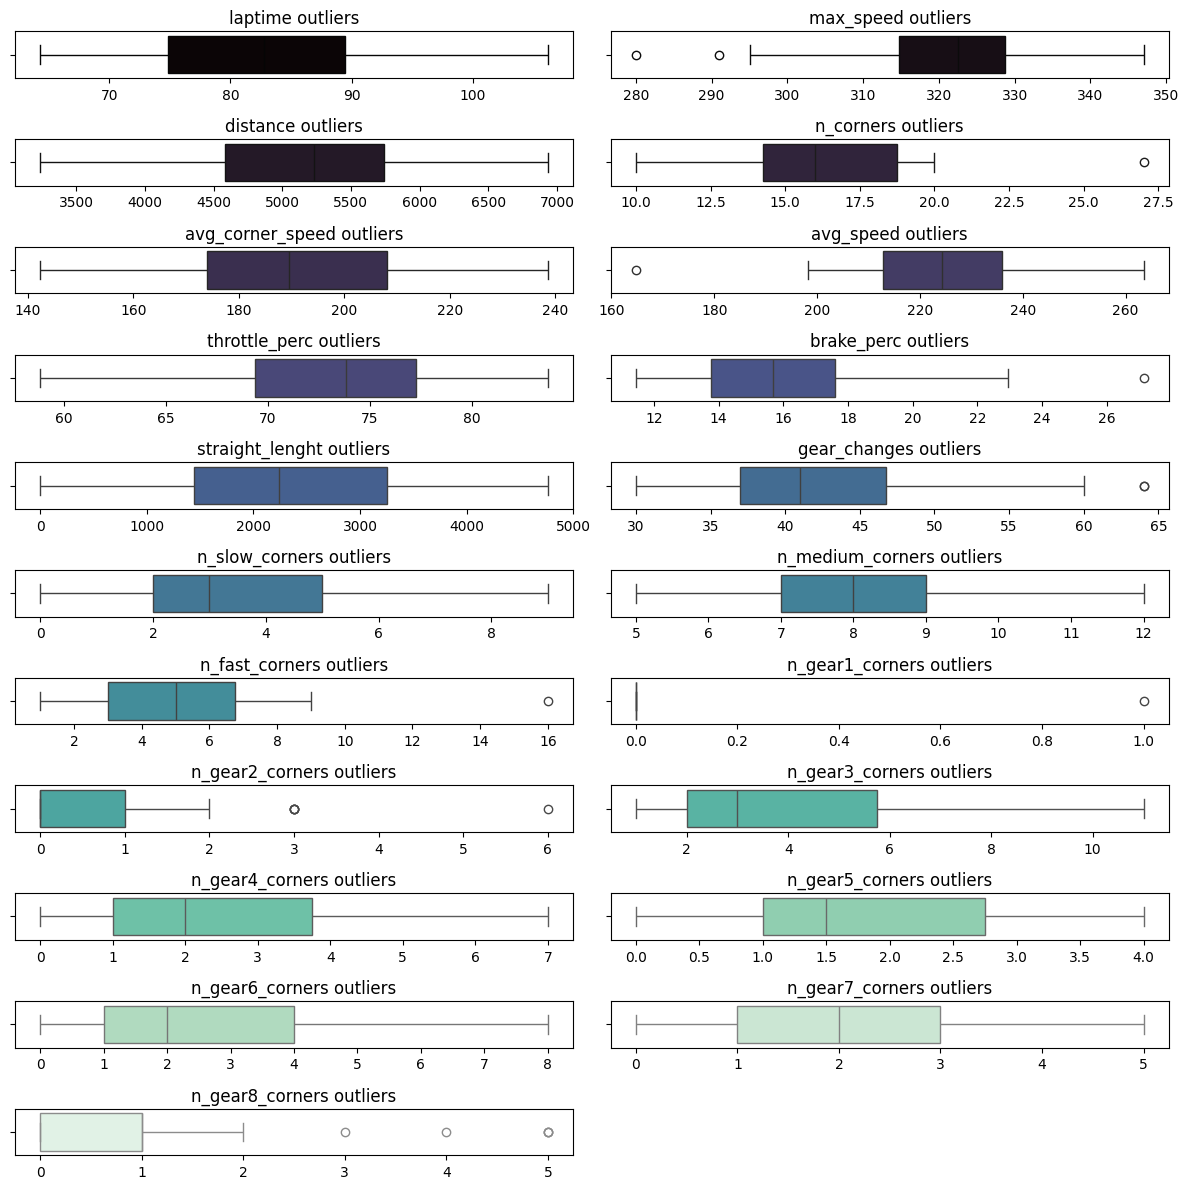

In [72]:
plot_outliers(df_circuits, size = (12, 12))

In the graph, we can see that there are practically no outliers, except for a few specific cases:

- The `Monaco` circuit has many very slow corners, resulting in outliers in brake percentage, average speed, and the number of corners taken in first or second gear. 

- On the other hand, the `Jeddah` circuit stands out for its large number of corners, especially high-speed ones.  

In the next cell, we can check the values for both circuits in the columns with outliers.

In [89]:
cols = ['max_speed', 'n_corners', 'avg_speed', 'brake_perc', 'n_gear1_corners', 'n_gear2_corners', 'n_gear8_corners', 'n_fast_corners']
tracks = ['monaco', 'jeddah']

df_circuits.loc[tracks][cols]

,max_speed,n_corners,avg_speed,brake_perc,n_gear1_corners,n_gear2_corners,n_gear8_corners,n_fast_corners
monaco,280.0,19,164.762082,27.137546,1,6,0,2
jeddah,330.0,27,254.070175,11.695906,0,0,5,16


Regarding `gear_changes`, we see that `Sochi`, `Marina Bay`, and `Baku` also stand out with high values, possibly due to the combination of acceleration and braking zones throughout the lap.

In [91]:
df_circuits['gear_changes'].sort_values(ascending=False).head()

sochi          64.0
marina_bay     64.0
baku           60.0
nurburgring    50.0
bahrain        48.0
Name: gear_changes, dtype: float64

### Correlation matrix

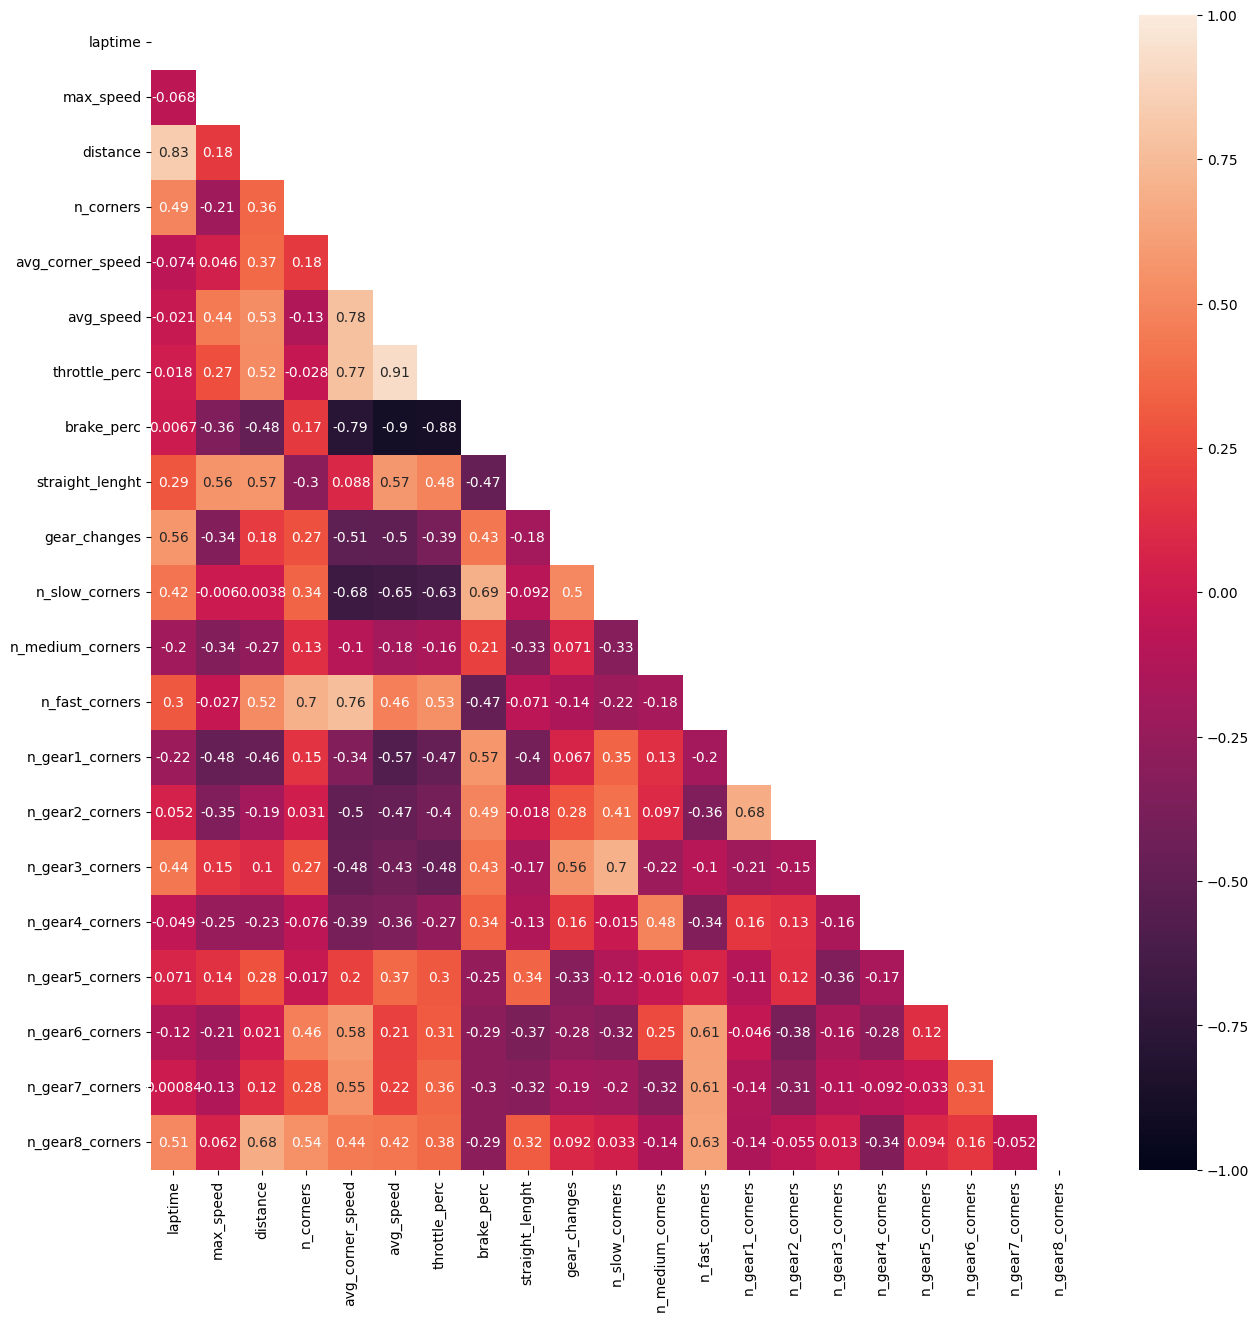

In [97]:
plot_correlation_matrix(df_circuits, size = (15, 15))

In the correlation matrix, we observe several interesting patterns. However, given the large number of columns, we will segment the information by focusing on the relationship between the number of corners and the corresponding gear shifts.  

Before proceeding with this segmentation, let's highlight some key insights:  

- Significant correlations (above 0.5 in absolute value) are observed between the number of corners in gears 6, 7, and 8, the number of fast corners, and the average cornering speed.  

- The number of corners taken in third gear shows a strong correlation with the total number of gear changes and the number of slow corners. This is particularly interesting, as this behavior does not occur in gears 1 and 2. These lower gears are less frequently used in a fast lap and are mainly required at race starts, in the pit lane, or on extremely slow circuits such as `Monaco`.  

- Overall, the correlation with other variables shifts between positive and negative when comparing gears 1-4 with gears 5-8. This suggests a possible classification into "short gears" and "long gears," which could help simplify the data analysis.  

Now, let's examine the correlation matrix without these columns to analyze the correlation between other variables.

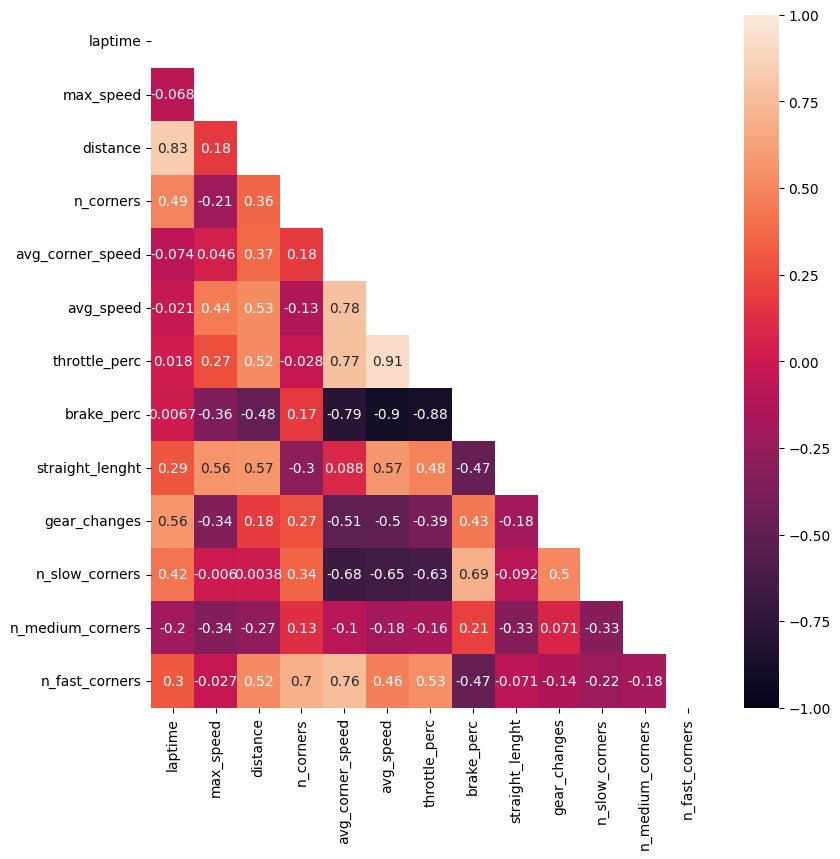

In [105]:
gear_columns = [f'n_gear{i}_corners' for i in range(1, 9)]

plot_correlation_matrix(df_circuits.drop(columns=gear_columns), size=(9,9))

We observe a very strong correlation (around 0.9 in absolute value) between `brake_perc`, `throttle_perc`, and `avg_speed`.  

This result makes sense, as the percentage of the lap where the throttle is not pressed usually coincides with moments when the brakes are applied. However, in some circuits, there is a small percentage of time where the driver simply lifts off the throttle without braking.  

Similarly, the relationship with `avg_speed` is expected, since a higher throttle percentage generally leads to a higher average speed.  

Given that these three variables are highly correlated and essentially explain each other, we could reduce redundancy by eliminating two of them and keeping only one.  

# 4. Feature engineering



En est

In [128]:
df_circuits.to_csv('../data/output/circuits_complete.csv')

In [134]:
def generate_features(df):

    df_featured = df.copy()

    df_featured['n_short_gear_corners'] = df_featured[['n_gear1_corners', 'n_gear2_corners', 'n_gear3_corners', 'n_gear4_corners']].sum(axis=1) / df['n_corners']
    df_featured['n_long_gear_corners'] = df_featured[['n_gear5_corners', 'n_gear6_corners', 'n_gear7_corners', 'n_gear8_corners']].sum(axis=1) / df['n_corners']

    df_featured[['n_slow_corners', 'n_medium_corners', 'n_fast_corners']] = df_featured[['n_slow_corners', 'n_medium_corners', 'n_fast_corners']].apply(lambda x: x / df_featured['n_corners'])

    cols = ['n_gear1_corners', 'n_gear2_corners', 'n_gear3_corners', 'n_gear4_corners', 'n_gear5_corners', 'n_gear6_corners', 'n_gear7_corners', 'n_gear8_corners']
    cols.extend([])

    df_featured.drop(columns=cols, inplace=True)

    return df_featured

Vamos a transformar ahora las variables extensivas en intensivas. Esto es, las variables que dependen de la longitud del circuito en variables que no lo hagan.

In [135]:
generate_features(df_circuits)

,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,straight_lenght,gear_changes,n_slow_corners,n_medium_corners,n_fast_corners,n_short_gear_corners,n_long_gear_corners
hockenheimring,71.767,320.0,4568.748333,17,209.960540,229.888136,78.359322,12.881356,1663.919441,40.0,0.176471,0.529412,0.294118,0.294118,0.705882
nurburgring,85.269,318.0,5112.340000,15,173.563856,216.201705,72.281250,17.329545,2043.790918,50.0,0.333333,0.466667,0.200000,0.466667,0.466667
portimao,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,1800.793691,40.0,0.266667,0.333333,0.400000,0.400000,0.600000
sochi,101.993,291.0,5789.306111,18,172.024977,204.520095,69.290780,17.494090,1284.998104,64.0,0.277778,0.444444,0.277778,0.666667,0.333333
istanbul,82.868,321.0,5253.130833,14,176.854350,228.286957,77.663768,15.072464,3877.396258,39.0,0.214286,0.571429,0.214286,0.571429,0.285714
ricard,90.872,330.0,5774.107500,15,179.153119,228.715976,74.056213,15.088757,3942.118895,44.0,0.200000,0.600000,0.200000,0.466667,0.400000
bahrain,89.165,317.0,5369.465278,15,175.267095,215.886567,73.588060,16.716418,3272.967594,48.0,0.200000,0.600000,0.200000,0.533333,0.466667
jeddah,87.472,330.0,6098.363611,27,238.630473,254.070175,83.728070,11.695906,1588.123443,42.0,0.074074,0.333333,0.592593,0.111111,0.740741
albert_park,75.915,326.0,5216.471667,14,208.500190,247.647887,82.665493,12.323944,3233.337712,34.0,0.142857,0.500000,0.357143,0.214286,0.642857
suzuka,88.197,295.0,5747.901944,18,210.314839,236.078261,77.391304,13.623188,2539.547594,34.0,0.166667,0.388889,0.444444,0.222222,0.777778


avg_speed realmente es distance entre laptime, por lo que simplemente dejamos distance como variable extensiva.

In [126]:
df_featured[['n_slow_corners', 'n_medium_corners', 'n_fast_corners']]

,n_slow_corners,n_medium_corners,n_fast_corners
hockenheimring,0.176471,0.529412,0.294118
nurburgring,0.333333,0.466667,0.200000
portimao,0.266667,0.333333,0.400000
sochi,0.277778,0.444444,0.277778
istanbul,0.214286,0.571429,0.214286
ricard,0.200000,0.600000,0.200000
bahrain,0.200000,0.600000,0.200000
jeddah,0.074074,0.333333,0.592593
albert_park,0.142857,0.500000,0.357143
suzuka,0.166667,0.388889,0.444444


---

Next steps

* Eliminar curvas que sean a fondo

* Incluir rectas

* Contar número de curvas en función de la velocidad

* Número de frenadas

Nota: deberíamos considerar eliminar las curvas que sean a fondo y/o agrupar las curvas o rectas por velocidad

Esto son next steps. Hacer si da tiempo

Más next steps: Añadir un campo que sea si es urbano o no y ver si hay diferencias significativas o cómo afecta a los clusters. Lo podríamos añadir a mano